### Imports

In [1]:
import numpy as np
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import torch.optim as optim

from PIL import Image

### Loading dataset

In [2]:
X = np.load("../dataset/X.npy")
y = np.load("../dataset/Y.npy")

In [3]:
X.shape, y.shape

((22801, 128, 128, 3), (22801, 1))

### Transforming dataset

In [4]:
image_size=32
mean=0
stddev=1

In [5]:
# Transforming X
X = X.astype(np.float32)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((mean,), (stddev,))
])

X_transformed = torch.stack([transform(image) for image in X])

In [6]:
# Transfomring y
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.ravel())
y_transformed = torch.tensor(y_encoded)

In [7]:
X_transformed.shape, y_transformed.shape

(torch.Size([22801, 3, 32, 32]), torch.Size([22801]))

### Creating TensorDataset

In [8]:
dataset = TensorDataset(X_transformed, y_transformed)

### Spliting dataset

In [9]:
train_ratio=0.7
valid_ratio=0.15
test_ratio=0.15

In [10]:
total_size = len(dataset)
train_size = int(train_ratio * total_size)
valid_size = int(valid_ratio * total_size)
test_size = total_size - train_size - valid_size

In [11]:
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

In [12]:
print(f"{'Dataset':<12} {'X Shape':<30} {'y Shape':<15}")
print(f"{'-'*12} {'-'*30} {'-'*15}")

print(f"{'Train':<12} {str(train_dataset.dataset.tensors[0][train_dataset.indices].shape):<30} {str(train_dataset.dataset.tensors[1][train_dataset.indices].shape):<15}")
print(f"{'Validation':<12} {str(valid_dataset.dataset.tensors[0][valid_dataset.indices].shape):<30} {str(valid_dataset.dataset.tensors[1][valid_dataset.indices].shape):<15}")
print(f"{'Test':<12} {str(test_dataset.dataset.tensors[0][test_dataset.indices].shape):<30} {str(test_dataset.dataset.tensors[1][test_dataset.indices].shape):<15}")

Dataset      X Shape                        y Shape        
------------ ------------------------------ ---------------
Train        torch.Size([15960, 3, 32, 32]) torch.Size([15960])
Validation   torch.Size([3420, 3, 32, 32])  torch.Size([3420])
Test         torch.Size([3421, 3, 32, 32])  torch.Size([3421])


### Creating DataLoaders

In [13]:
batch_size=32
train_shuffle=True
valid_shuffle=False
test_shuffle=False

In [14]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=train_shuffle)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=valid_shuffle)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=test_shuffle)

### Model definition

##### CNN Layers Shape Calculation

$$
H_{\text{out}} = \left\lfloor \frac{H_{\text{in}} + 2 \times \text{padding}[0] - \text{dilation}[0] \times ( \text{kernel\_size}[0] - 1 ) - 1}{\text{stride}[0]} \right\rfloor + 1
$$

$$
W_{\text{out}} = \left\lfloor \frac{W_{\text{in}} + 2 \times \text{padding}[1] - \text{dilation}[1] \times ( \text{kernel\_size}[1] - 1 ) - 1}{\text{stride}[1]} \right\rfloor + 1
$$

where:

- $H_{\text{in}}$ is the input height.
- $W_{\text{in}}$ is the input width.
- $\text{padding}[0]$ is the padding added to the input height.
- $\text{padding}[1]$ is the padding added to the input width.
- $\text{dilation}[0]$ is the dilation factor for the convolutional kernel in the height dimension.
- $\text{dilation}[1]$ is the dilation factor for the convolutional kernel in the width dimension.
- $\text{kernel\_size}[0]$ is the height of the convolutional kernel.
- $\text{kernel\_size}[1]$ is the width of the convolutional kernel.
- $\text{stride}[0]$ is the stride of the convolution in the height dimension.
- $\text{stride}[1]$ is the stride of the convolution in the width dimension.

In [15]:
def calculate_h_out_w_out(h_in, w_in, kernel_size, out_channels, stride=(1, 1), padding=(0, 0), dilation=(1, 1)):
    h_out = (h_in + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) // stride[0] + 1
    w_out = (w_in + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) // stride[1] + 1

    # assert
    assert isinstance(h_out, int), "Output height is not an integer"
    assert isinstance(w_out, int), "Output width is not an integer"
    
    return (h_out, w_out, out_channels)

In [16]:
class CNN(Module):
    def __init__(self, in_height, in_width, in_channels, num_classes):
        super(CNN, self).__init__()

        self.in_features = (in_height, in_width, in_channels)
        self.conv1 = Conv2d(in_channels=in_channels, out_channels=16, kernel_size=(5, 5), padding=(2, 2))
        self.in_features = calculate_h_out_w_out(in_height, in_width, (5, 5), 16, padding=(2, 2))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.in_features = calculate_h_out_w_out(self.in_features[0], self.in_features[1], (2, 2), self.in_features[2], stride=(2, 2))
        
        #self.conv2 = Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5))
        #self.in_features = calculate_h_out_w_out(self.in_features[0], self.in_features[1], (5, 5), 32)
        #self.relu2 = ReLU()
        #self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        #self.in_features = calculate_h_out_w_out(self.in_features[0], self.in_features[1], (2, 2), self.in_features[2], stride=(2, 2))
        
        self.fc1 = Linear(in_features=self.in_features[0] * self.in_features[1] * self.in_features[2], out_features=2048)
        self.relu3 = ReLU()

        self.fc2 = Linear(in_features=2048, out_features=512)
        self.relu4 = ReLU()

        self.fc3 = Linear(in_features=512, out_features=num_classes)
        self.logSoftmax = LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        #x = self.conv2(x)
        #x = self.relu2(x)
        #x = self.maxpool2(x)

        x = flatten(x, 1)
        
        x = self.fc1(x)
        x = self.relu3(x)

        x = self.fc2(x)
        x = self.relu4(x)

        x = self.fc3(x)
        x = self.logSoftmax(x)
        return x

### Training

##### Function for choosing the device 

In [17]:
def get_device():
  return torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### Function for counting number of paramaters for model

In [18]:
def count_parameters(model):
  total_params = sum(p.numel() for p in model.parameters())

  # Iterate through the layers and print their details
  for name, layer in model.named_children():
        num_params = sum(p.numel() for p in layer.parameters())
        print(f"Layer: {name}, Parameters: {num_params}")

  return total_params

##### Function for training

In [19]:
def train(model, criterion, optimizer, n_epochs, train_loader, valid_loader, multiclass=False):
    # Initialize lists for traininf and validation loss and accuracy for each epoch
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    # Get the appropriate device
    device = get_device()

    # Iterate over each epoch
    for epoch in range(n_epochs):
        # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> TRAINING <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

        model.train()                                # Set the model to training mode
        
        epoch_train_batches_loss = 0.0               # Loss for the current epoch
        epoch_train_correct_predictions = 0          # Number of correct predictions
        epoch_train_total_predictions = 0            # Total number of instances processed

        # Iterate over batches in the training data loader
        for inputs, labels in train_loader:
            # Move inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Gradients from the previous batch are zeroed out to prevent accumulation
            optimizer.zero_grad()
            
            # Compute the model output
            outputs = model(inputs)
            
            # Compute the loss based on the criterion passed 
            loss = criterion(outputs.squeeze(), labels)
            
            # Compute the gradients
            loss.backward()
            
            # Update the model parameters using the optimizer
            optimizer.step()

            # Accumulate the loss for the current batch
            epoch_train_batches_loss += loss.item()

            # Predict
            if multiclass:
                predicted = torch.argmax(outputs, dim=1)
            else:
                predicted = (outputs > 0.5).float()
            
            # Update the number of correct predictions
            epoch_train_correct_predictions += (predicted.squeeze() == labels).sum().item()
            
            # Update the total number of instances processed
            epoch_train_total_predictions += labels.size(0)

        # Calculate the average loss for the training epoch
        epoch_train_loss = epoch_train_batches_loss / len(train_loader)
        
        # Calculate the accuracy for the training epoch
        epoch_train_accuracy = epoch_train_correct_predictions / epoch_train_total_predictions
        
        # Store the loss and accuracy for training
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> VALIDATION <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

        model.eval()                               # Set the model to evaluation mode
        
        epoch_valid_loss = 0.0                       # Loss for the current validation epoch
        epoch_valid_correct_predictions = 0          # Number of correct predictions
        epoch_valid_total_predictions = 0            # Total number of instances processed
        
        with torch.no_grad():  # Disable gradient computation for validation
            for inputs, labels in valid_loader:
                # Move inputs and labels to the device
                inputs, labels = inputs.to(device), labels.to(device)

                # Compute the model output
                outputs = model(inputs)
                
                # Compute the loss based on the criterion passed 
                loss = criterion(outputs.squeeze(), labels)
                
                # Accumulate the loss for the current batch
                epoch_valid_loss += loss.item()

                # Predict
                if multiclass:
                    predicted = torch.argmax(outputs, dim=1)
                else:
                    predicted = (outputs > 0.5).float()
                
                # Update the number of correct predictions
                epoch_valid_correct_predictions += (predicted.squeeze() == labels).sum().item()
                
                # Update the total number of instances processed
                epoch_valid_total_predictions += labels.size(0)
        
        # Calculate the average loss and accuracy for the validation epoch
        epoch_valid_loss /= len(valid_loader)
        epoch_valid_accuracy = epoch_valid_correct_predictions / epoch_valid_total_predictions

        valid_losses.append(epoch_valid_loss)
        valid_accuracies.append(epoch_valid_accuracy)
        
        print(f"Epoch [{epoch + 1}/{n_epochs}], Train Loss: {epoch_train_loss:.4f}, "
              f"Train Accuracy: {epoch_train_accuracy:.4f}, "
              f"Val Loss: {epoch_valid_loss:.4f}, Val Accuracy: {epoch_valid_accuracy:.4f}")

    # Return the losses and accuracies over all epochs
    return train_losses, train_accuracies, valid_losses, valid_accuracies

##### Instantiate model

In [20]:
image_height = image_size
image_width = image_size
n_channels = X.shape[3]
print(image_height, image_width, n_channels)
n_classes = len(np.unique(y))

32 32 3


In [21]:
model = CNN(in_height=image_height, in_width=image_width, in_channels=n_channels, num_classes=n_classes)
model

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=512, out_features=27, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)

##### Counting number of parameters

In [22]:
count_parameters(model)

Layer: conv1, Parameters: 1216
Layer: relu1, Parameters: 0
Layer: maxpool1, Parameters: 0
Layer: fc1, Parameters: 8390656
Layer: relu3, Parameters: 0
Layer: fc2, Parameters: 1049088
Layer: relu4, Parameters: 0
Layer: fc3, Parameters: 13851
Layer: logSoftmax, Parameters: 0


9454811

##### Train

In [23]:
n_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [24]:
train_losses, train_accuracies, valid_losses, valid_accuracies = train(model, criterion, optimizer, n_epochs, train_loader, valid_loader, True)

Epoch [1/10], Train Loss: 2.6756, Train Accuracy: 0.1935, Val Loss: 2.0094, Val Accuracy: 0.3626
Epoch [2/10], Train Loss: 1.7468, Train Accuracy: 0.4459, Val Loss: 1.5354, Val Accuracy: 0.5278
Epoch [3/10], Train Loss: 1.2380, Train Accuracy: 0.6044, Val Loss: 1.3422, Val Accuracy: 0.5795
Epoch [4/10], Train Loss: 0.8418, Train Accuracy: 0.7274, Val Loss: 1.0982, Val Accuracy: 0.6602
Epoch [5/10], Train Loss: 0.5534, Train Accuracy: 0.8179, Val Loss: 1.0874, Val Accuracy: 0.6801
Epoch [6/10], Train Loss: 0.3480, Train Accuracy: 0.8885, Val Loss: 1.0822, Val Accuracy: 0.7041
Epoch [7/10], Train Loss: 0.2111, Train Accuracy: 0.9340, Val Loss: 1.2478, Val Accuracy: 0.7023
Epoch [8/10], Train Loss: 0.1431, Train Accuracy: 0.9537, Val Loss: 1.3460, Val Accuracy: 0.6985
Epoch [9/10], Train Loss: 0.1134, Train Accuracy: 0.9637, Val Loss: 1.3622, Val Accuracy: 0.7208
Epoch [10/10], Train Loss: 0.1003, Train Accuracy: 0.9690, Val Loss: 1.5677, Val Accuracy: 0.7035


### Ploting results of the training

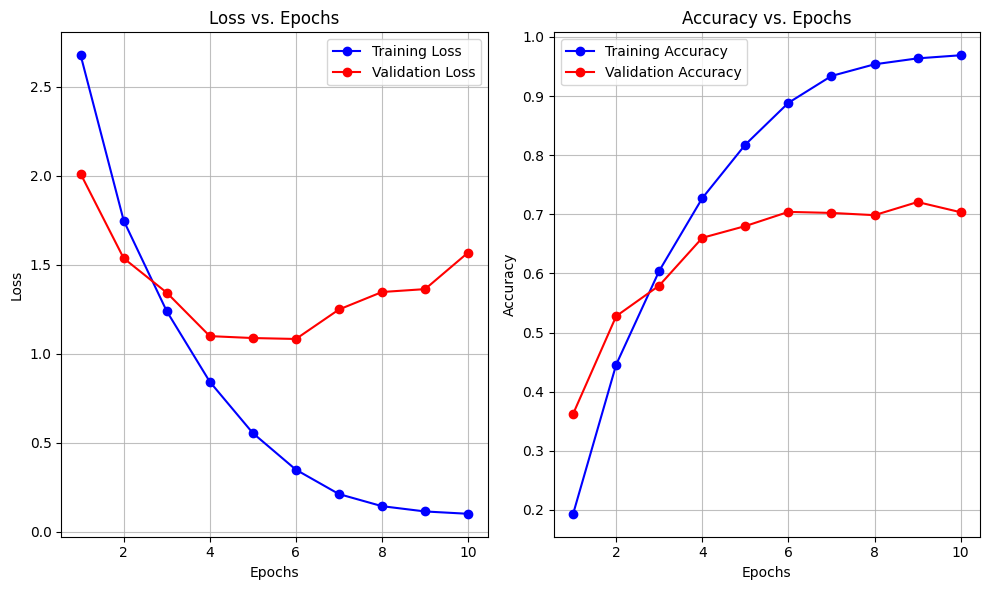

In [37]:
def plot_training_curves(train_losses, train_accuracies, valid_losses, valid_accuracies):
    FIGSIZE=(10, 6)
    DPI=100
    ALPHA=0.8
    
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=FIGSIZE, dpi=DPI)
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, valid_losses, 'ro-', label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid('on', alpha=ALPHA)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, valid_accuracies, 'ro-', label='Validation Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid('on', alpha=ALPHA)
    
    plt.tight_layout()
    plt.show()

plot_training_curves(train_losses, train_accuracies, valid_losses, valid_accuracies)